In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-a3nodeset-2
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
# group.add_argument("--seed", type=int, default=0)
# group.add_argument("--save_dir", type=str, default=None)

# group = parser.add_argument_group("model")
# group.add_argument("--grid_size", type=int, default=64)
# group.add_argument("--rollout_steps", type=int, default=4096)

# group = parser.add_argument_group("data")
# group.add_argument("--n_rollout_imgs", type=int, default=32)
# group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

# group = parser.add_argument_group("optimization")
# group.add_argument("--bs", type=int, default=512)
# group.add_argument("--start", type=int, default=0) # start range for params search
# group.add_argument("--end", type=int, default=262144) # end range for params search

NameError: name 'group' is not defined

In [4]:
cfg_default = dict(
    seed=0, save_dir=None,

    grid_size=64, rollout_steps=2048,
    n_rollout_imgs=32,

    bs=512,
    start=0, end=262144,
)

n_splits = 8
split_size = (2**18)//n_splits

seed = 0
cfgs = []
for i in range(n_splits):
    cfg = cfg_default.copy()
    cfg.update(seed=seed, start=i*split_size, end=(i+1)*split_size)
    cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/gol/split={i}_{seed=}")
    cfgs.append(cfg)

print(len(cfgs))

8


In [5]:
commands = experiment_utils.create_commands(cfgs, prefix='python main_sweep_gol.py', out_file='../science_scripts/main_sweep_gol.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=0_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=0      --end=32768 
python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=1_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=32768  --end=65536 
python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=2_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=65536  --end=98304  
...
8 commands


# Visualize Results

In [6]:
import jax
import jax.numpy as jnp
from jax.random import split

In [7]:
data = []
all_params = []
for cfg in cfgs[:]:
    save_dir = cfg['save_dir']
    print(save_dir)
    data.append(util.load_pkl(save_dir, "data"))
    all_params.append(util.load_pkl(save_dir, "all_params"))

/home/akarsh_sakana_ai/nca-alife-data/gol/split=0_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=1_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=2_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=3_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=4_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=5_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=6_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=7_seed=0


In [8]:
data = jax.tree.map(lambda *x: jnp.concatenate(x, axis=0), *data)
all_params = jax.tree.map(lambda *x: jnp.concatenate(x, axis=0), *all_params)

2024-09-03 19:15:29.608875: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
cgol = 6152 # conway's game of life

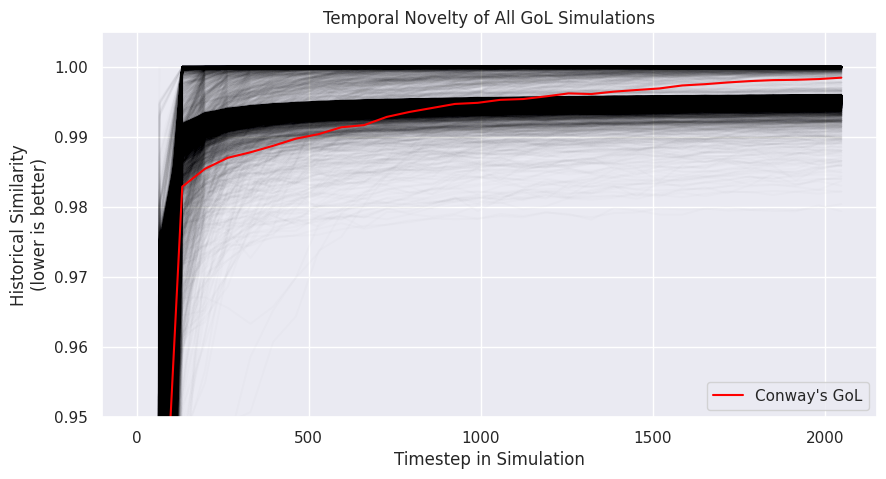

In [172]:
timesteps = np.linspace(0, 2048, 32)
plt.figure(figsize=(10, 5))
plt.plot(timesteps, data['loss_novelty'][:10000].T, c='black', alpha=0.01)
plt.plot(timesteps, data['loss_novelty'][cgol], c='red', label="Conway's GoL");
plt.legend()
plt.ylim(0.95, 1.005)
plt.xlabel("Timestep in Simulation")
plt.ylabel("Historical Similarity\n(lower is better)")
plt.title("Temporal Novelty of All GoL Simulations")
plt.show()

In [11]:
time_cutoff = 2048+64
oe_scores = data['loss_novelty'][:, 1:time_cutoff//64].mean(axis=-1)

percentile of cgol:  0.9668006896972656


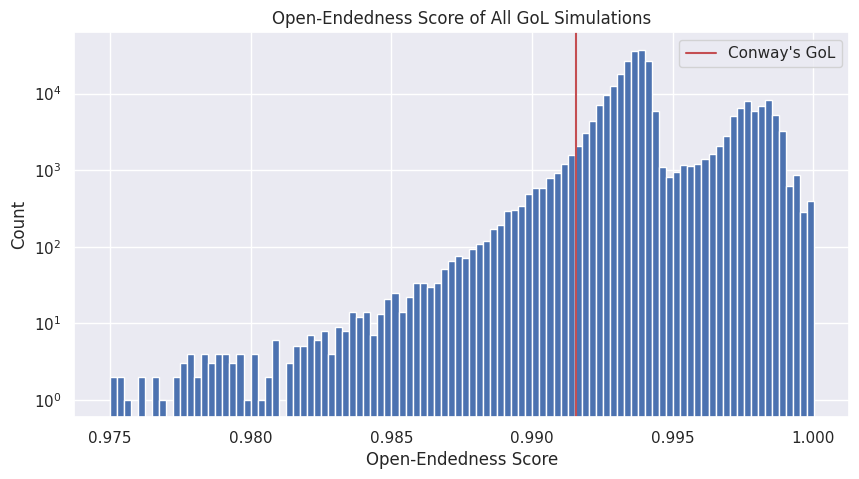

In [182]:
plt.figure(figsize=(10, 5))
plt.hist(oe_scores, bins=100);
plt.axvline(oe_scores[cgol], c='r', label="Conway's GoL")
plt.yscale('log')
cgol_percentile = (oe_scores[cgol]<oe_scores).sum()/len(oe_scores)
print('percentile of cgol: ', cgol_percentile.item())

plt.xlabel("Open-Endedness Score")
plt.ylabel("Count")
plt.title("Open-Endedness Score of All GoL Simulations")
plt.legend()
plt.show()

In [44]:
idx_best = oe_scores.argsort()

In [14]:
idx_best[0]

Array(133519, dtype=int32)

In [15]:
from models.models_gol import int2binary, GameOfLife

def rule2english(x):
    x = np.array(int2binary(x))
    dead_rules = x[:9]
    alive_rules = x[9:]
    
    dead_rules = [str(i) for i in np.nonzero(dead_rules)[0]]
    dead_rules = ",".join(dead_rules)
    alive_rules = [str(i) for i in np.nonzero(alive_rules)[0]]
    alive_rules = ",".join(alive_rules)

    rule = f"a dead cell with {{{dead_rules}}} live neighbors becomes live\na live cell with {{{alive_rules}}} live neighbors lives"
    return rule

def unroll_params(rng, params, sim, rollout_len=2048, img_size=64, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img
    
sim = GameOfLife()
unroll_fn = partial(unroll_params, sim=sim)

In [16]:
rng = jax.random.PRNGKey(1)

In [17]:
import imageio

0
0.9245015382766724

1
0.9421007037162781

2
0.9217796325683594

3
0.940741240978241

4
0.911983847618103

5
0.9464942216873169

6
0.94743412733078

7
0.8902833461761475

8
0.023513570427894592



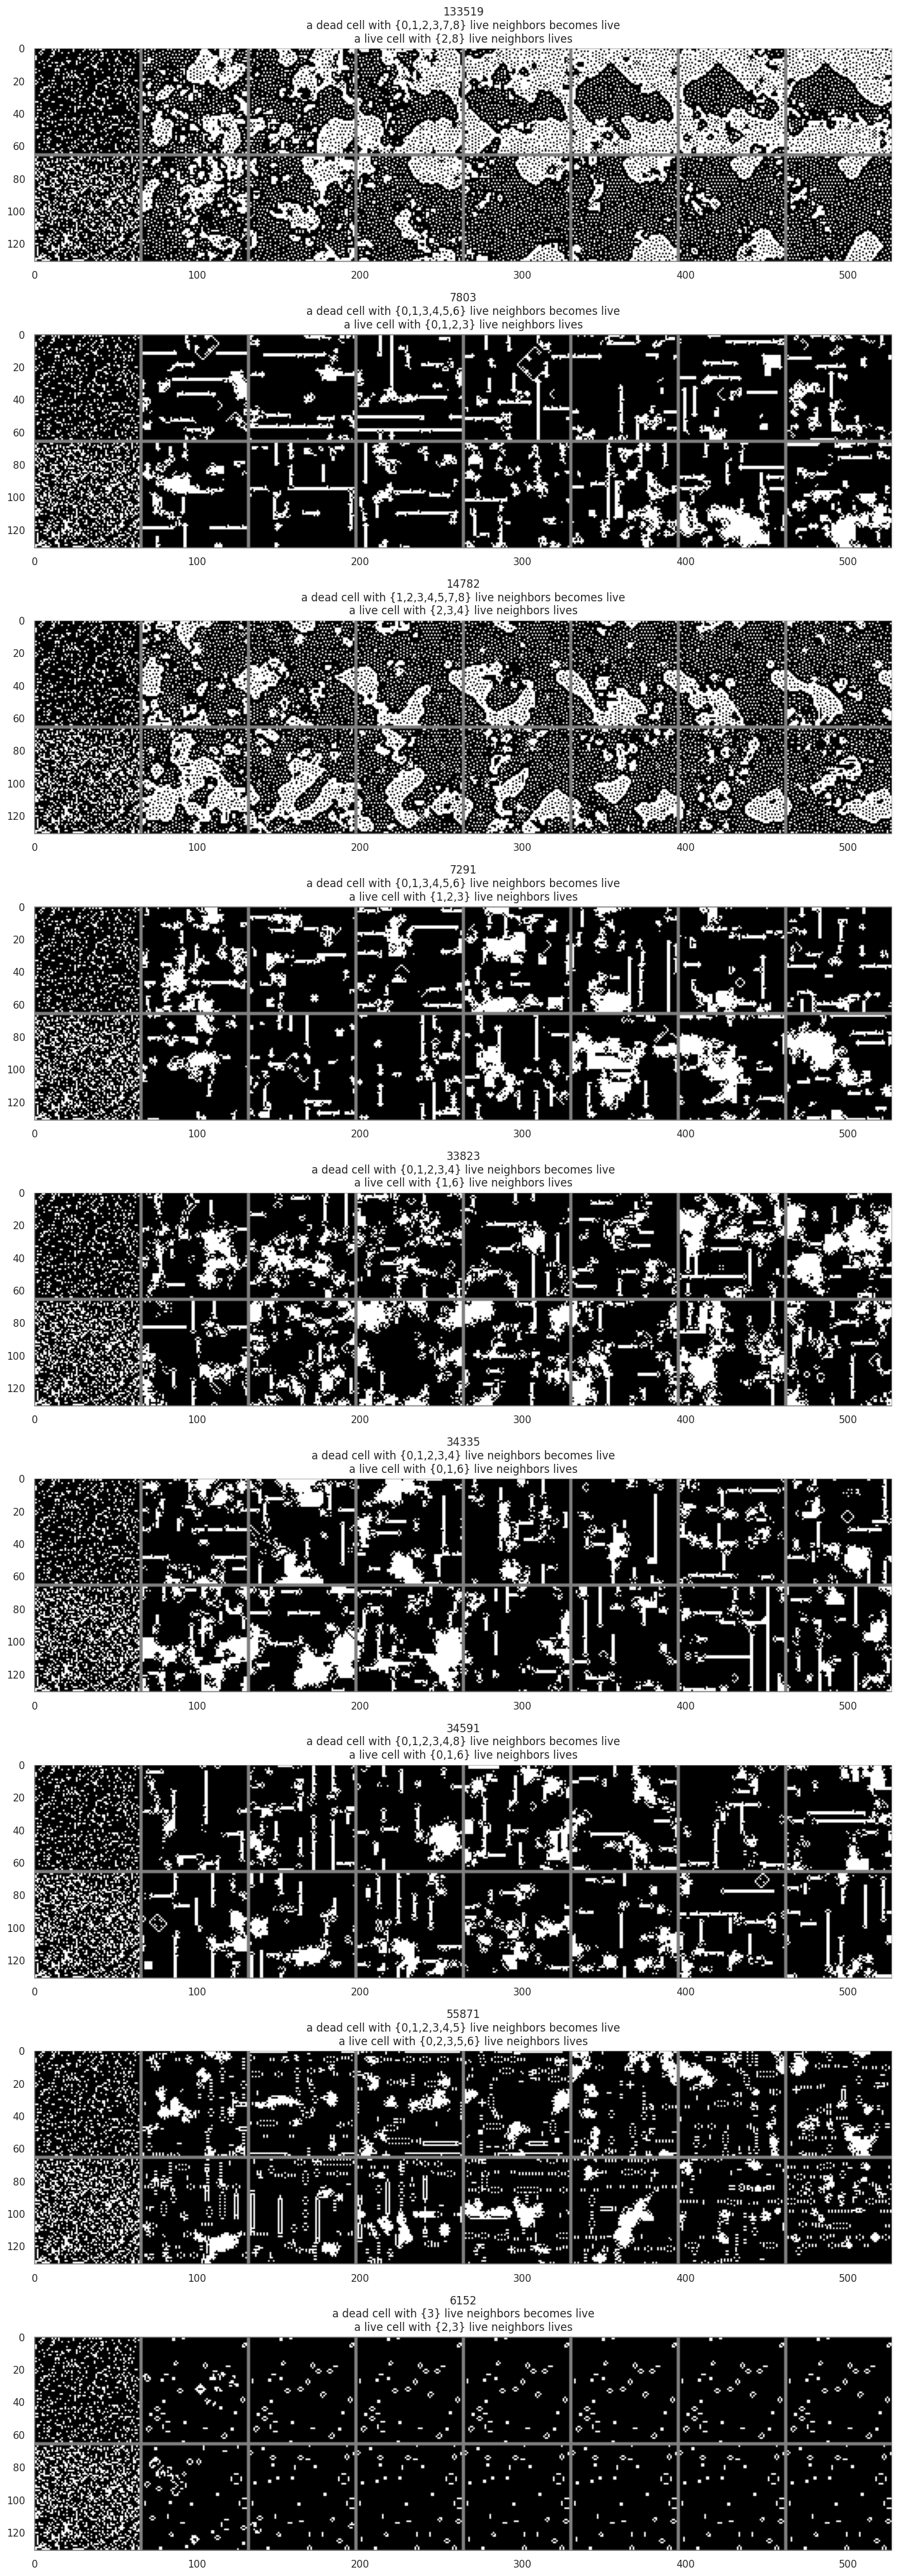

In [200]:
plt.figure(figsize=(20, 40))
for i, ip in enumerate(idx_best[:8].tolist()+[cgol]):
    params = all_params[ip]
    vid = jax.vmap(unroll_fn, in_axes=(0, None))(split(rng, 16), params)
    print(i)
    print((jnp.abs(vid[:, 1:]-vid[:, :-1])).mean().item())
    print()

    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)

    # --------- IMAGES ---------
    plt.subplot(8+1, 1, i+1)
    plt.imshow(rearrange(vid[:2, ::256], "B T H W D -> (B H) (T W) D"))
    plt.grid(False)
    plt.title(f"{params}\n{rule2english(params)}")

    # --------- SAVE GIFS ---------
    # vid = rearrange(vid[:16, :2048:2], "(R C) T H W D -> T (R H) (C W) D", R=4)
    # vid = np.array((vid*255).astype(jnp.uint8))
    # imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/gol/vids/{i}.gif", vid, fps=15)

plt.tight_layout()
plt.show()

(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66, 66, 3)
(1, 2048, 66,

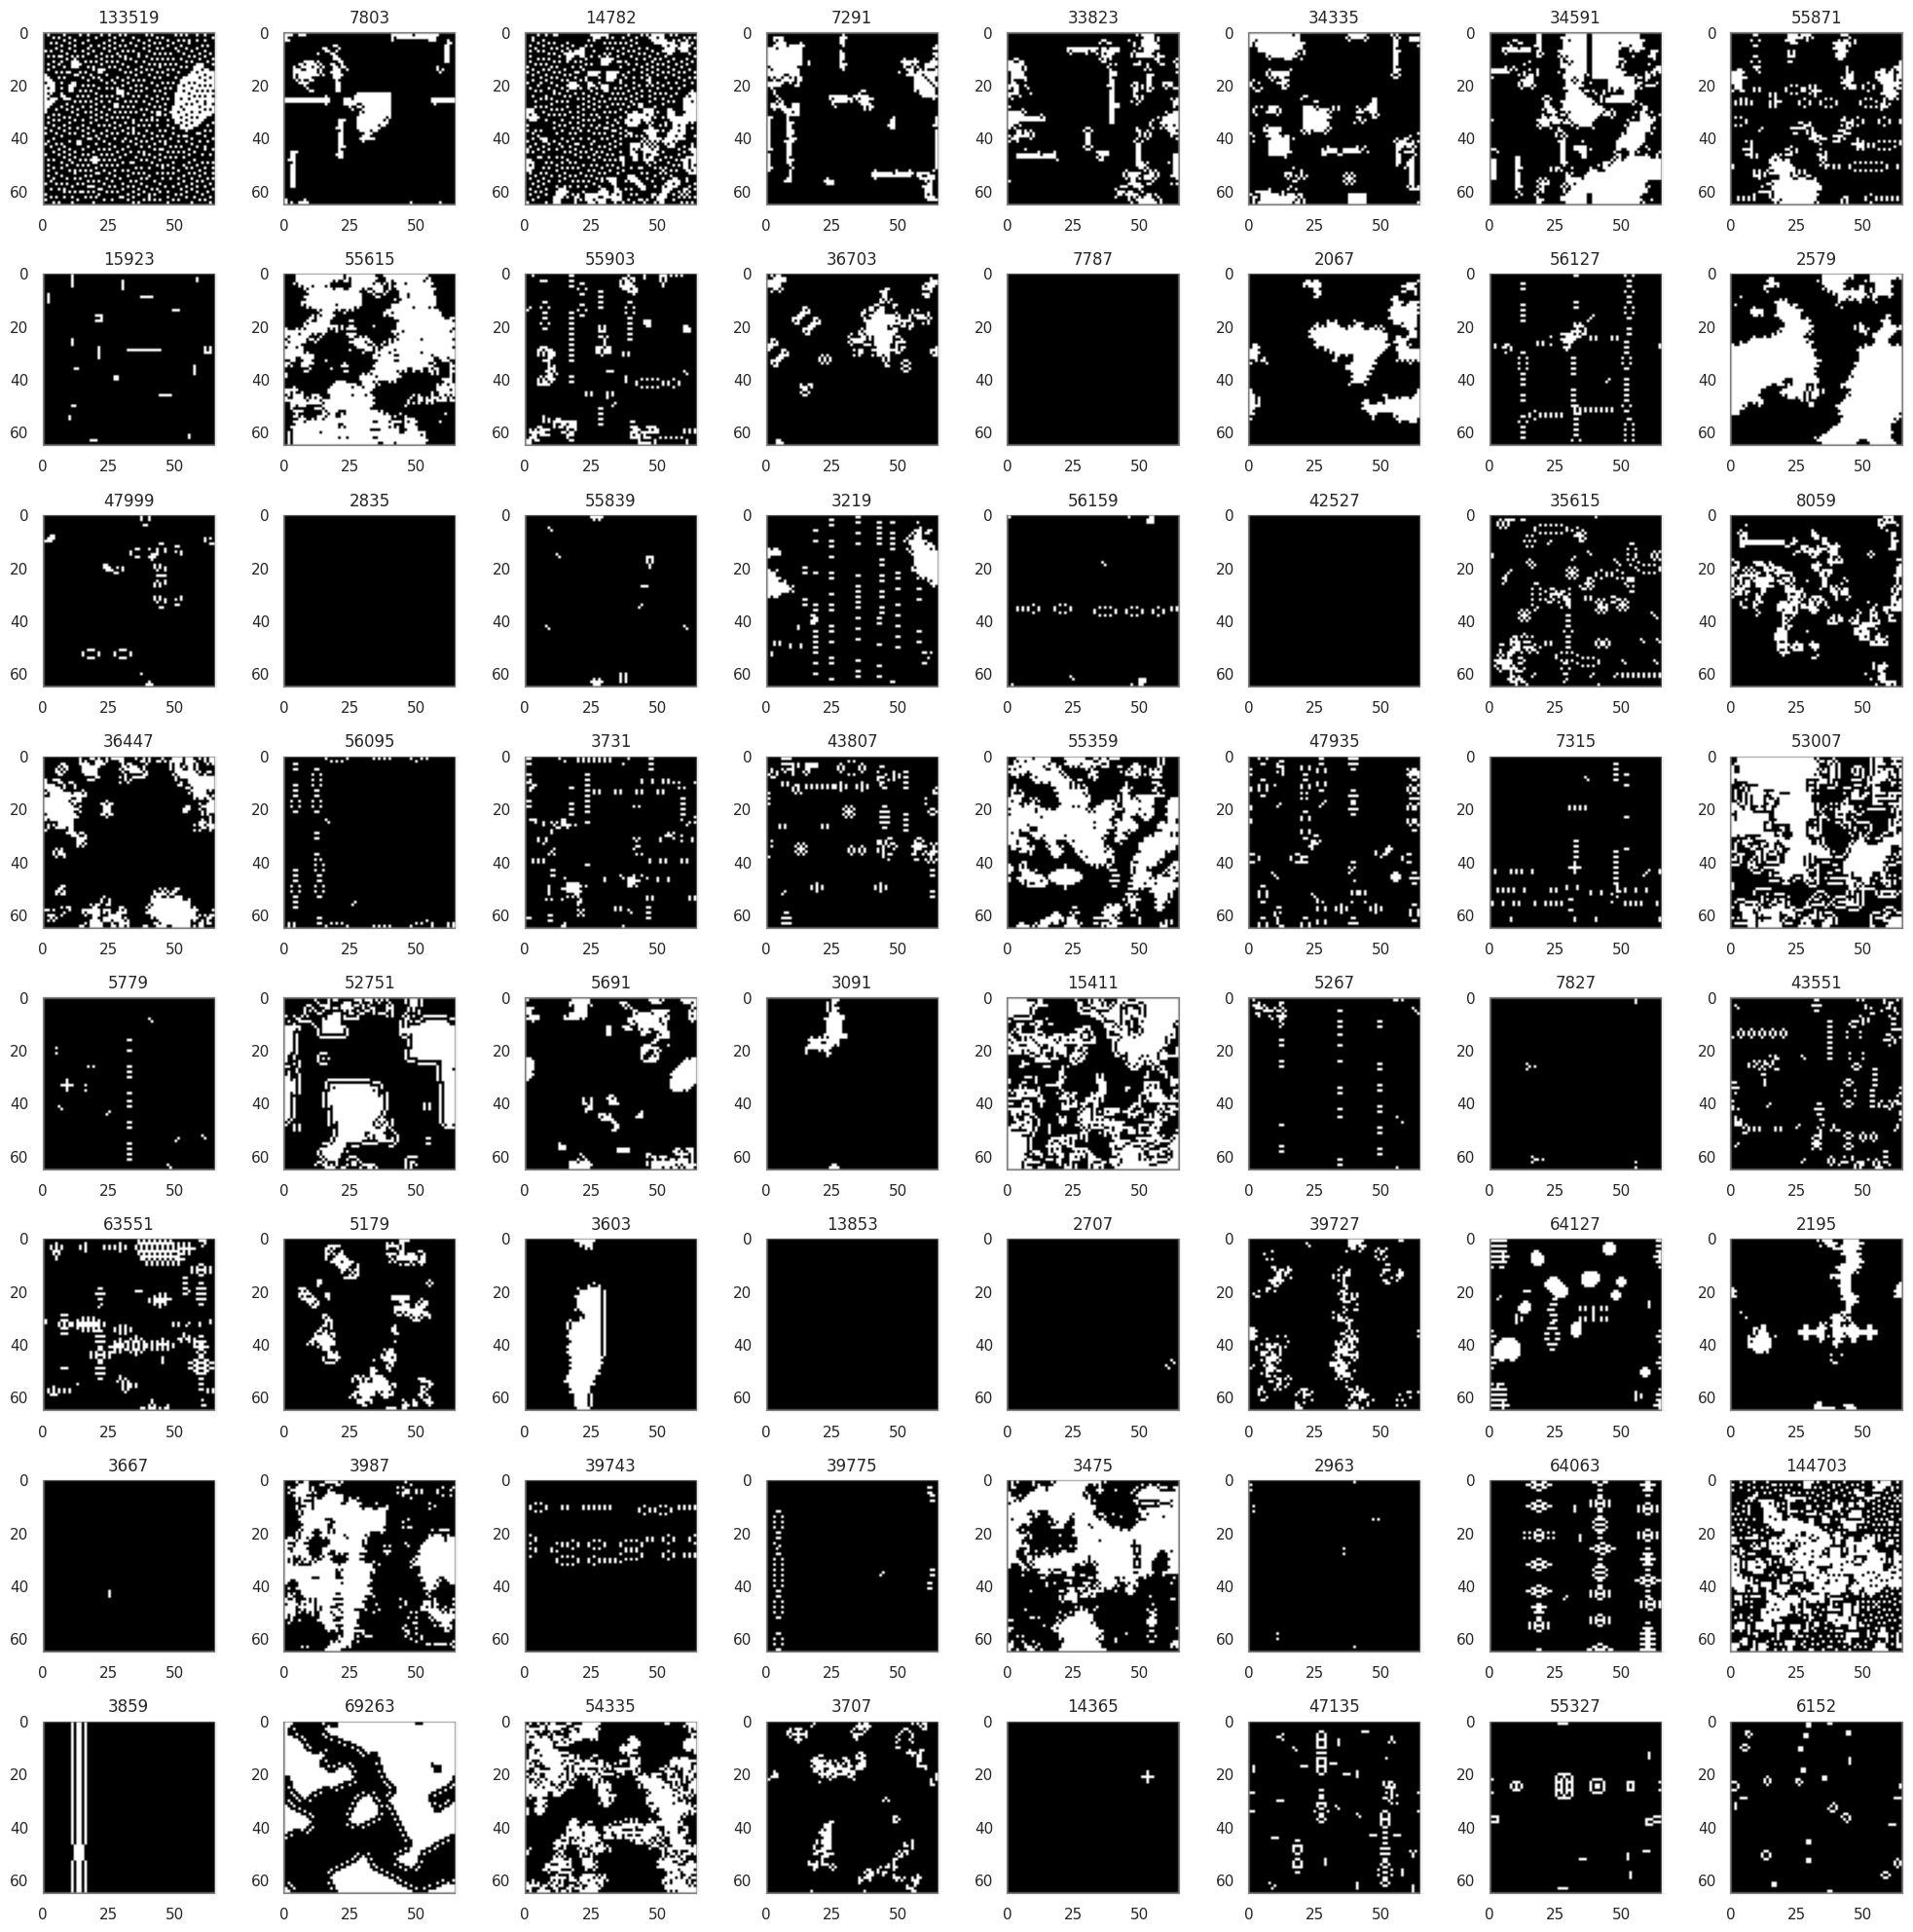

In [206]:
plt.figure(figsize=(20, 20))
for i, ip in enumerate(idx_best[:63].tolist()+[cgol]):
    params = all_params[ip]
    vid = jax.vmap(unroll_fn, in_axes=(0, None))(split(rng, 1), params)
    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
    print(vid.shape)
    # --------- IMAGES ---------
    plt.subplot(8, 8, i+1)
    img1, img2 = vid[0, -2], vid[0, -1]
    img = img1 if (img1.mean().item()<img2.mean().item()) else img2
    plt.imshow(img)
    plt.grid(False)
    plt.title(f"{params}")
    # plt.title(f"{params}\n{rule2english(params)}")

    # --------- SAVE GIFS ---------
    # vid = rearrange(vid[:16, :2048:2], "(R C) T H W D -> T (R H) (C W) D", R=4)
    # vid = np.array((vid*255).astype(jnp.uint8))
    # imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/gol/vids/{i}.gif", vid, fps=15)

plt.tight_layout()
plt.show()

In [51]:
vid.shape

(16, 2048, 66, 66, 3)

In [18]:
from umap import UMAP

In [19]:
oe_scores.shape

(262144,)

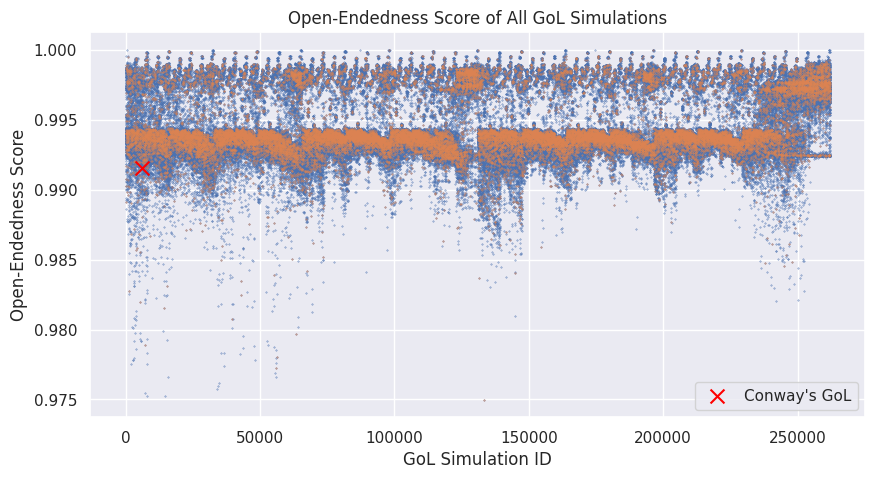

In [191]:
plt.figure(figsize=(10, 5))
plt.scatter(all_params, oe_scores, s=0.1)
plt.scatter(all_params[idx_best[::10]], oe_scores[idx_best[::10]], s=0.1)

plt.scatter(cgol, oe_scores[cgol], s=100.0, c='red', marker='x', label="Conway's GoL")
plt.legend()
plt.xlabel("GoL Simulation ID")
plt.ylabel("Open-Endedness Score")
plt.title("Open-Endedness Score of All GoL Simulations")
plt.show()

In [123]:
np.random.seed(0)
z = data['z_img_final'][idx_best[::10]]
print(z.shape)
# img_final = pop['img_final']
# z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
# z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
umap_fn = UMAP(n_components=2, metric='cosine').fit(z)
z_2d = umap_fn.transform(z)
z_2d_cgol = umap_fn.transform(data['z_img_final'][cgol][None])[0]
print(z_2d.shape)

(26215, 512)
(26215, 2)


In [125]:
z_2d_cgol.shape

(2,)

Text(0.5, 1.0, 'UMAP of GoL Simulation CLIP Embeddings colored by Open-Endedness Score')

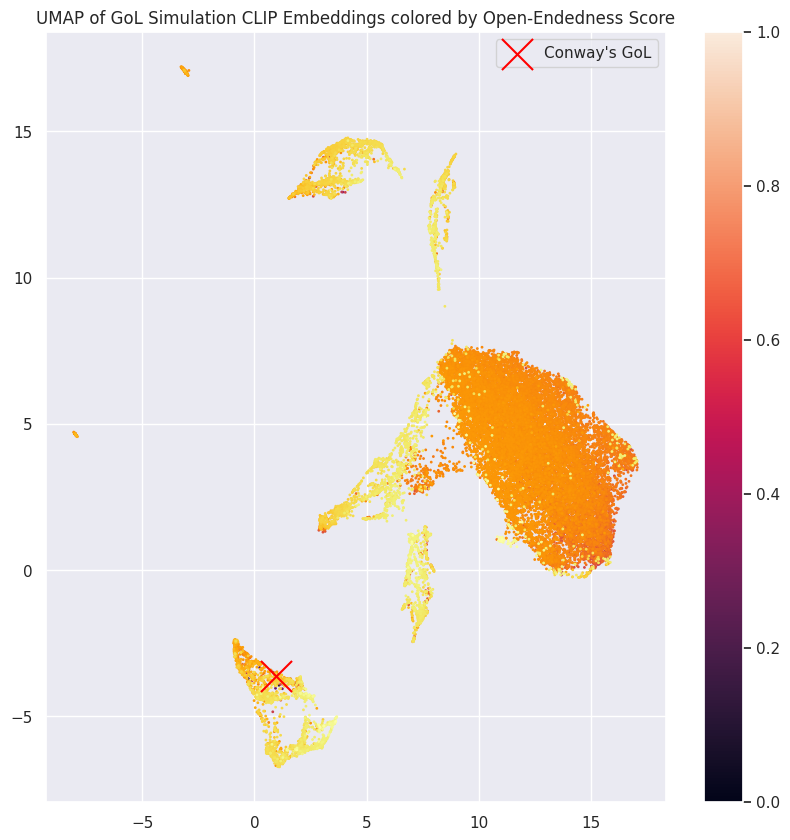

In [184]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_2d.T, c=oe_scores[idx_best[::10]], s=1.0, cmap='inferno')
plt.scatter(*z_2d_cgol, c='red', s=500.0, marker='x', label="Conway's GoL")
plt.colorbar()
plt.legend()
# plt.xlim(0,20)
# plt.ylim(-7,15)
plt.title("UMAP of GoL Simulation CLIP Embeddings colored by Open-Endedness Score")

In [133]:
all_params_bin = jax.vmap(int2binary)(all_params)
all_params_bin.shape

(262144, 18)

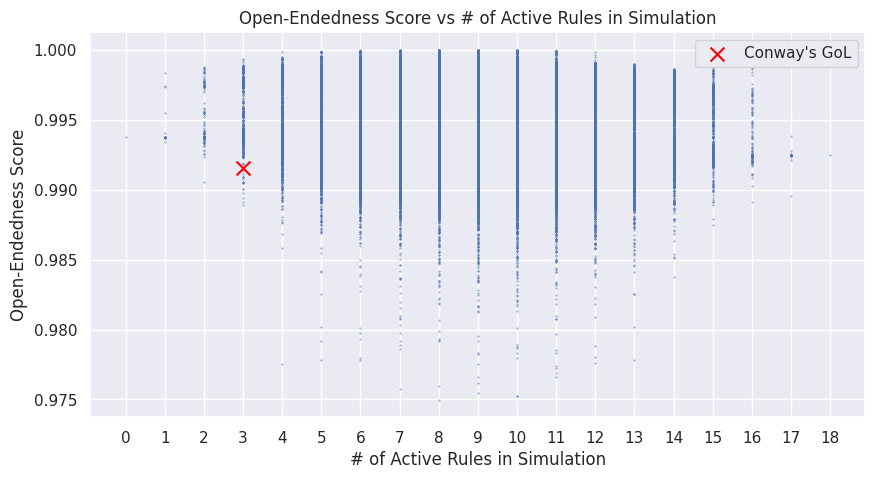

In [197]:
plt.figure(figsize=(10, 5))
plt.scatter(all_params_bin.sum(axis=-1), oe_scores, s=0.1)
plt.scatter(all_params_bin[cgol].sum(), oe_scores[cgol], c='red', s=100.0, marker='x', label="Conway's GoL")

plt.legend()

plt.xlabel("# of Active Rules in Simulation")
plt.ylabel("Open-Endedness Score")
plt.title("Open-Endedness Score vs # of Active Rules in Simulation")

plt.xticks(np.arange(18+1))
plt.show()

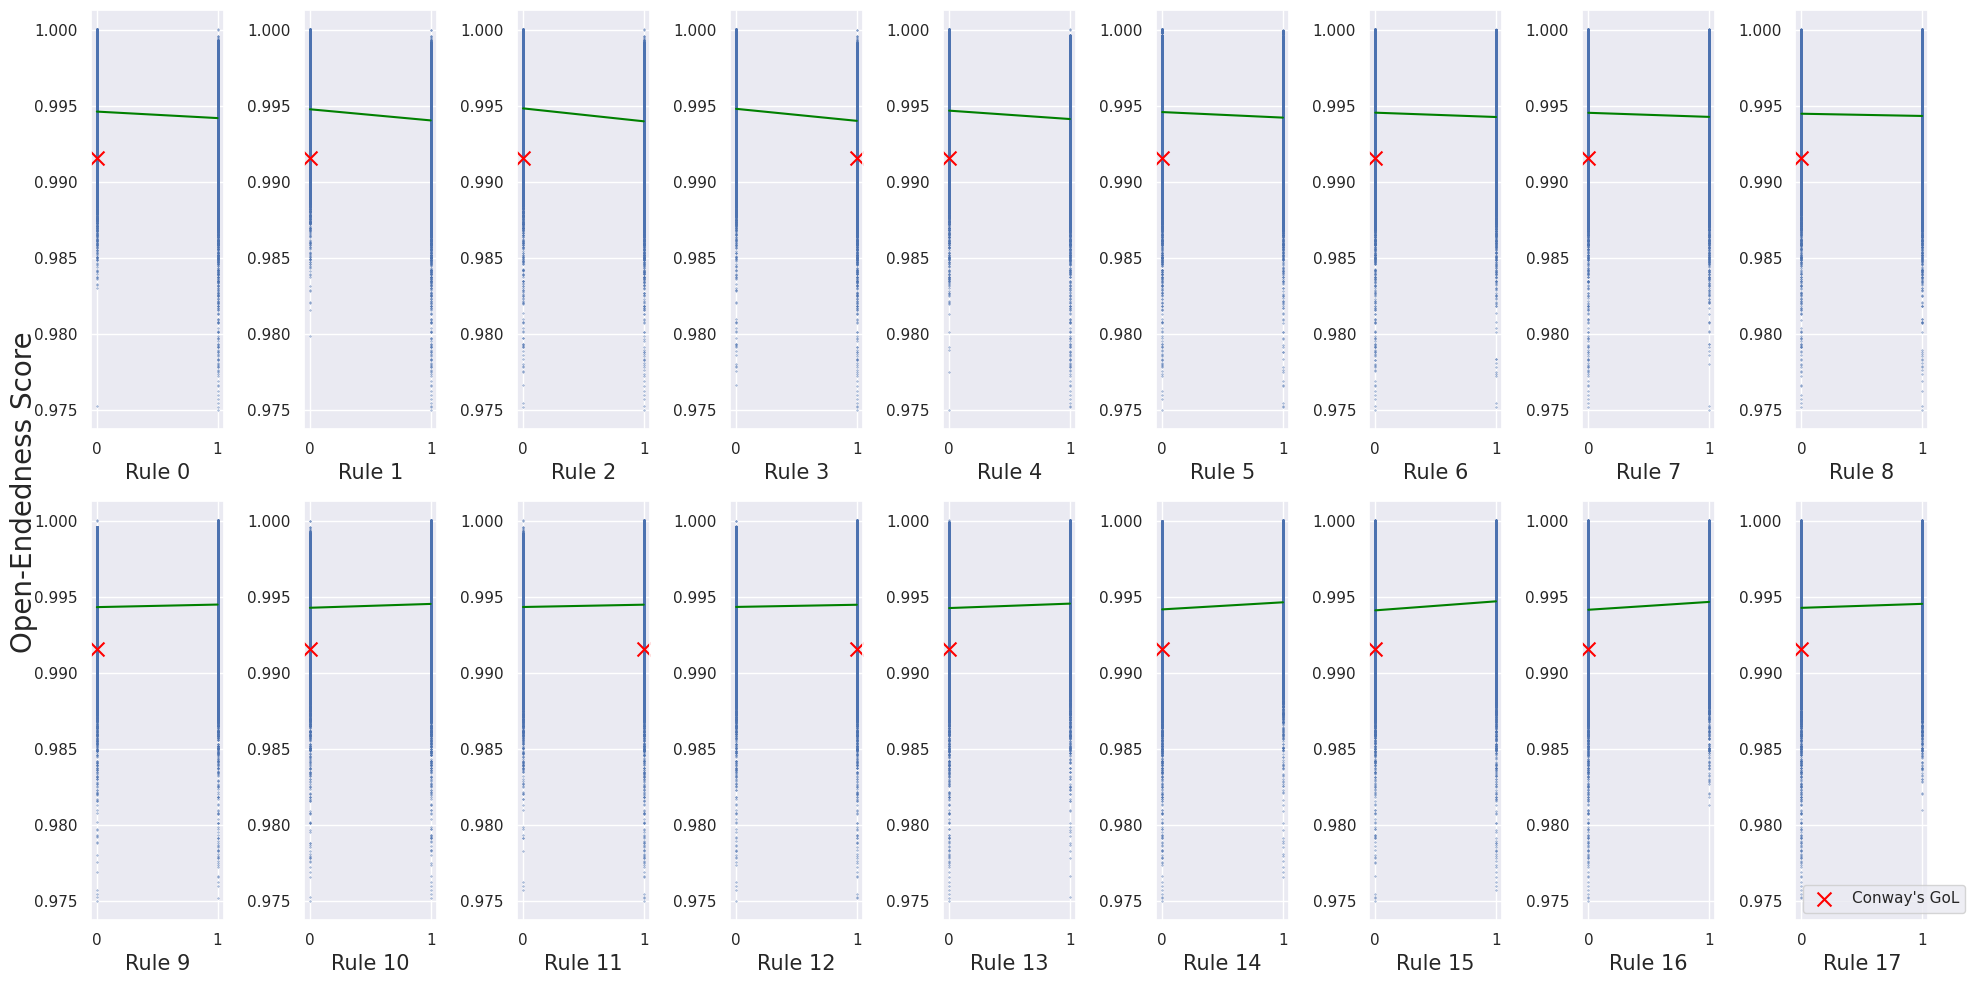

In [190]:
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(2, 9, i+1)
    plt.scatter(all_params_bin[:, i], oe_scores, s=0.1)
    plt.scatter(all_params_bin[cgol, i], oe_scores[cgol], c='red', s=100.0, marker='x', label="Conway's GoL")
    plt.plot([jnp.mean(oe_scores[all_params_bin[:, i]==0]), jnp.mean(oe_scores[all_params_bin[:, i]==1])], c='green')
    plt.xlabel(f"Rule {i}", fontsize=15)

plt.gcf().supylabel("Open-Endedness Score", fontsize=20)

plt.legend()
plt.tight_layout()
plt.show()

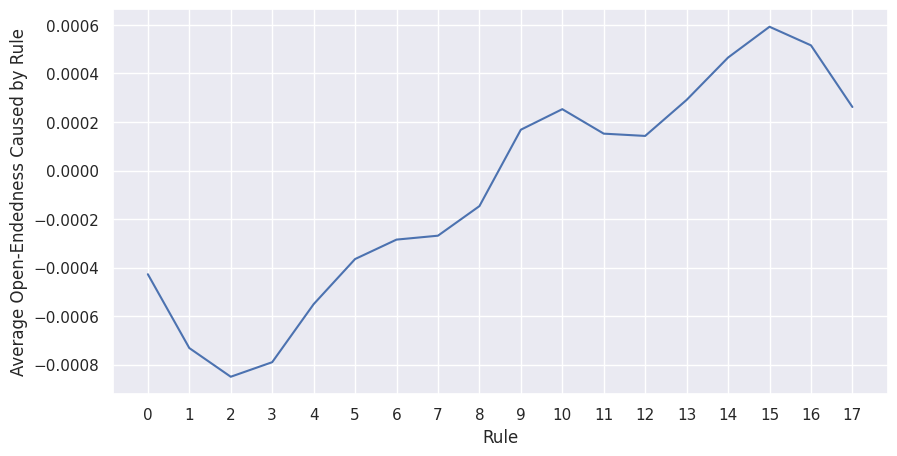

In [194]:
plt.figure(figsize=(10, 5))
slopes = []
for i in range(18):
    slopes.append(jnp.mean(oe_scores[all_params_bin[:, i]==1])-jnp.mean(oe_scores[all_params_bin[:, i]==0]))
plt.plot(slopes)

plt.xticks(np.arange(18))

plt.ylabel("Average Open-Endedness Caused by Rule")
plt.xlabel("Rule")

plt.show()